In [1]:
pip install bitstring

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from copy import deepcopy
from bitstring import BitStream, BitArray
from matplotlib import pyplot as plt

In [3]:
# The treasure hoard is where the treasure is held
class treasure_hoard:
  item_count = 0
  items = []
  def __init__(self,total_item_count, seed):
    np.random.seed = seed 
    self.max_value = np.random.randint(50,100)
    self.min_value = np.random.randint(0,3)
    self.max_length = np.random.randint(3,10)
    self.min_length = np.random.randint(1,3)
    self.max_weight = np.random.randint(3,20)
    self.min_weight = np.random.randint(1,3)

    for _ in range(total_item_count):
      self.items.append(treasure_item(self.max_value,self.max_length,self.max_weight,min_value=self.min_value, min_length= self.min_length, min_weight=self.min_weight))
  def display(self):
    print( "max value: " + str(self.max_value) + ", " +  str(self.min_value) + "\n" + "max length: " + str(self.max_length) + ", " +  str(self.min_length) + "\n" + "max weight: " + str(self.max_weight) + ", " +  str(self.min_weight))

In [4]:
# Treasure item is a single piece of treasure
# The treasure item has a value, length and weight 
class treasure_item:
  value = 0
  length = 0
  weight = 0
  def __init__(self, max_value,max_length, max_weight,min_value = 0, min_length = 1, min_weight = 1):
    self.value = np.random.randint(min_value,max_value)
    self.length = np.random.randint(min_length,max_length)
    self.weight = np.random.randint(min_weight,max_weight)

  def display(self):
    print("Item Value "+ str(self.value) + " length " + str(self.length) + " weight " + str(self.weight))

In [5]:
# The treasure must not be over a certain weight and length,the fitnes function is used to insure it is the correct
# weight and length
# The max weight and length are defined here
class problem(): 
  total_value = 0
  total_length = 0
  total_weight = 0
  fitness_to_weight_length_ratio = 0

  def __init__(self):
    self.max_items = 50
    self.min_items = 10 
    self.max_length = 240
    self.max_weight = 300
    self.number_of_treasure_items = 100

  def fitness_function(self, items, treasure):
    self.total_value, self.total_length, self.total_weight = totals_in_knapsack(items, treasure)
    if (self.total_length < self.max_length) and (self.total_weight <= self.max_weight) and (items.bin.count("1")<= 50 and items.bin.count("1") >= 10):
      self.fitness_to_weight_length_ratio = self.total_value/(self.total_weight+self.total_length)
      return (self.total_value, self.fitness_to_weight_length_ratio)
    else:
      return "Incomatable treasure item"

In [6]:
# The parameters for the problem are changed here 
class parameters:
  def __init__(self):
    self.number_in_population = 100
    self.number_of_iterations = 200

    #children
    self.child_rate = 1
    self.number_of_children = self.number_in_population * self.child_rate

    #tournament selection parameters
    self.competitors_per_match = 3
    self.matches_per_round = 9

    #Crossover Rate
    self.crossover_rate = 0.5
    self.crossover_explore_rate = 0.5

    #Mutation parameters
    self.mutation_rate = 0.1
    self.mutation_range = 0.5

    #Explore exploit
    self.explore_exploit = .99

In [7]:
# This function tallies up the weight, length and value and returns it to the fitness function 
def totals_in_knapsack(items, treasure):
  value = 0
  length = 0
  weight = 0

  for i in range(len(items)):
    if items[i] is True:
      value += treasure.items[i].value
      length += treasure.items[i].length
      weight += treasure.items[i].weight
  return value, length, weight

In [8]:
# The individual is the knapsack of treasure,the cromosone is the items taken from the treaure hoard, 
class individual():
  #items
  chromosone = None

  fitness = 0
  fitness_to_weight_length_ratio=0

  prob = None

  #constructor
  def __init__(self, problem = problem()):
    self.prob = problem
    self.chromosone = BitArray(bin = '0'*self.prob.number_of_treasure_items)

    if problem is not None:
      for _ in range(np.random.randint(low=self.prob.min_items, high=self.prob.max_items)):
        self.chromosone[np.random.randint(self.prob.number_of_treasure_items)] = True
        values = self.prob.fitness_function(self.chromosone, treasure) 
        self.fitness = values[0] 
        self.fitness_to_weight_length_ratio = values[1]
        
# The crossover combines the genetic information of two parents into one child  

  def crossover(self, other_parent, explore_rate):
    child1 = deepcopy(self)
    child2 = deepcopy(other_parent)
    alpha = np.random.randint(self.prob.number_of_treasure_items)
    beta = np.random.randint(alpha, self.prob.number_of_treasure_items)
    child1.chromosone = self.chromosone[0:alpha] + other_parent.chromosone[alpha:beta] + self.chromosone[beta:self.prob.number_of_treasure_items]
    child2.chromosone = other_parent.chromosone[0:alpha] + self.chromosone[alpha:beta] + other_parent.chromosone[beta:self.prob.number_of_treasure_items]
    
    return child1, child2

# The mutation is used to add a different item to the knapsack,for this mutation a bitstring was used 

  def mutate(self, mutation_rate, mutation_range):
    item_list = list(self.chromosone.bin)
    for i in range(len(item_list)):
      if np.random.rand()<mutation_rate:
        item_list[i] = str(int(not bool(int(item_list[i])))) 
    self.chromosone.bin = "".join(item_list)

In [9]:
# The methods used for parent selection are random, roulete and tournamant 
# Random selection
# In this strategy we randomly select parents from the existing population
def choose_distinct_pair_from(number_in_pop):
  index1 = np.random.randint(number_in_pop)
  index2 = np.random.randint(number_in_pop)
  if index1 == index2:
    return choose_distinct_pair_from(number_in_pop)
  else:
    return index1,index2

In [10]:
# Roulete selection
# In roulette wheel selection, each individual has a chance to be selected. 
# The chance of an individual to be selected is based on the fitness value of the individual. 
# Fitter individuals have a higher chance to be selected.
def roulette_wheel_index_selection(pop):
  fitness_array = []
  
  for i in range(len(pop)):
    fitness_array.append(pop[i].fitness)

  cumulative_total_array = np.cumsum(fitness_array)
  parent1_from_cumulative_total_array = sum(fitness_array) * np.random.rand()
  parent2_from_cumulative_total_array = sum(fitness_array) * np.random.rand()
  
  index1 = np.argwhere(parent1_from_cumulative_total_array <= cumulative_total_array)
  index2 = np.argwhere(parent2_from_cumulative_total_array <= cumulative_total_array)
    
  if index1[0][0] != index2[0][0]:
    return index1[0][0], index2[0][0]
  else:
     return roulette_wheel_index_selection(pop)

In [11]:
# Tournament selection
#  Tournament selection involves running several "tournaments" among a few individuals (or "chromosomes") 
# chosen at random from the population
def tournament_selection(pop, competitors_per_match, matches_per_round):
  #get indexes for individual contestants
  parent1_sample = np.random.randint(low=0, high=len(pop), size=competitors_per_match*matches_per_round).tolist()
  parent2_sample = np.random.randint(low=0, high=len(pop), size=competitors_per_match*matches_per_round).tolist()

  parent1_contestants=[]
  parent2_contestants=[]
  #get contestants
  for k in range(len(parent1_sample)):
    parent1_contestants.append(pop[parent1_sample[k]])
    parent2_contestants.append(pop[parent2_sample[k]])
  
  #go until there's a winner
  while len(parent1_contestants) != 1:#len(competitors)
    #show winners
    parent1_winners=[]
    parent2_winners=[]
    #show competitors 
    parent1_competitors=[]
    parent2_competitors=[]
    #split into size rounds
    for i in range(0, len(parent1_contestants), competitors_per_match):
      parent1_competitors.append(parent1_contestants[i:i+competitors_per_match])
      parent2_competitors.append(parent2_contestants[i:i+competitors_per_match])
    #sort
    for j in range(len(parent1_competitors)):
      #get winner 
      parent1_winners.append(sorted(parent1_competitors[j], key = lambda x:x.fitness, reverse=True)[0])
      parent2_winners.append(sorted(parent2_competitors[j], key = lambda x:x.fitness, reverse=True)[0])
  
    #winners of each round become contestants
    parent1_contestants=parent1_winners
    parent2_contestants=parent2_winners

  parent1=parent1_contestants[0]
  parent2=parent2_contestants[0]

  if parent1 != parent2:
    return parent1, parent2
  else:
    return tournament_selection(pop, competitors_per_match, matches_per_round)

In [12]:
def run_genetic(problem, parameters):
  fitness = []

  #read problem 
  fitness_function = problem.fitness_function

  #read parameters
  number_in_population = parameters.number_in_population
  number_of_iterations = parameters.number_of_iterations
  number_of_children = parameters.number_of_children
  crossover_rate = parameters.crossover_rate
  crossover_explore_rate = parameters.crossover_explore_rate
  mutation_rate = parameters.mutation_rate
  mutation_range = parameters.mutation_range
  explore_exploit = parameters.explore_exploit
  competitors_per_match = parameters.competitors_per_match
  matches_per_round = parameters.matches_per_round


  #placeholder for best case
  best_solution = deepcopy(individual())
  best_solution.fitness = 0
  best_solution.fitness_to_weight_length_ratio=0

  population = []
  fitnesses = []
  while len(population) <= number_in_population:
    new_individual = individual(problem)
    if isinstance(new_individual.fitness, (int)):
      population.append(new_individual)
      fitnesses.append(new_individual.fitness)

      if new_individual.fitness > best_solution.fitness:
        best_solution = deepcopy(new_individual)
  population = sorted(population, key = lambda x:x.fitness, reverse=True)
  fitnesses = sorted(fitnesses, reverse=True)

  for i in range(number_of_iterations):
    children = []
    #generate childs
    while len(children) <= number_of_children:
      parent1_index, parent2_index = roulette_wheel_index_selection(population)
      parent1 = population[parent1_index]
      parent2 = population[parent2_index]

      #crossover
      child1, child2 = parent1.crossover(parent2, crossover_explore_rate)
      
      #mutate
      child1.mutate(mutation_rate, mutation_range)
      child2.mutate(mutation_rate, mutation_range)
      values = fitness_function(child1.chromosone, treasure)
      child1.fitness = values[0]
      child1.fitness_to_weight_length_ratio = values[1]
      values = fitness_function(child2.chromosone, treasure)
      child2.fitness = values[0]
      child2.fitness_to_weight_length_ratio = values[1]
      if isinstance(child1.fitness, (int)):
        children.append(child1)
      if isinstance(child2.fitness, (int)):
        children.append(child2)  
    # Add children to population
    population += children


    # sort/reduce population to correct level
    population = sorted(population, key = lambda x:x.fitness, reverse=True)[:number_in_population]
    
    if population[0].fitness > best_solution.fitness:
      best_solution = deepcopy(population[0])
      
    fitness.append(best_solution.fitness)
  return best_solution, number_of_iterations, fitness

In [13]:
prob = problem()
params = parameters()

In [14]:
treasure = treasure_hoard(500, 1967)

In [15]:
best_soln, num_iterations, fitness = run_genetic(prob, params)

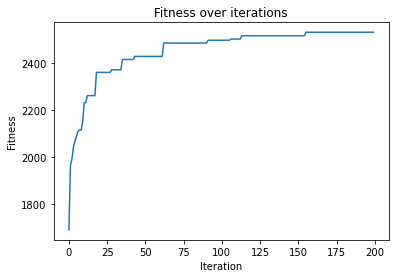

Best Solution: 2533


In [16]:
#random parent selection results

x = np.arange(num_iterations)
y = np.array(fitness)
plt.title("Fitness over iterations") 
plt.xlabel("Iteration") 
plt.ylabel("Fitness") 
plt.plot(x,y) 
plt.show()
print("Best Solution: " + str(best_soln.fitness))

# 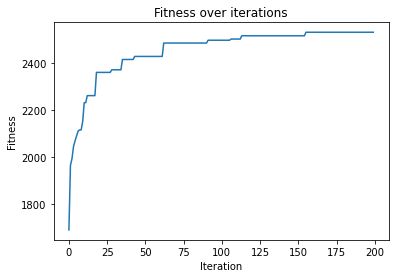
Best Solution 2533

In [17]:
# tnumber as seed
treasure = treasure_hoard(500, 202371)

In [18]:
prob = problem()
params = parameters()

In [19]:
best_soln, num_iterations, fitness = run_genetic(prob, params)

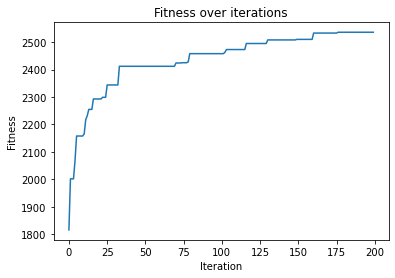

Best Solution: 2536


In [20]:
x = np.arange(num_iterations)
y = np.array(fitness)
plt.title("Tnumber as seed") 
plt.xlabel("Iteration") 
plt.ylabel("Fitness") 
plt.plot(x,y) 
plt.show()
print("Best Solution: " + str(best_soln.fitness))

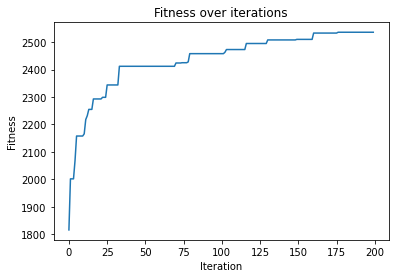 
Best solution 2536

In [ ]:
competitors_per_round=2
number_of_rounds=10
sample = np.random.randint(low=1, high=100, size=number_of_rounds*competitors_per_round).tolist()
no_rounds=0

print("sample: " + str(sample))
while len(sample) != 1:
  no_rounds+=1
  winners=[]
  competitors=[]
  #split
  for i in range(0, len(sample), competitors_per_round):
    competitors.append(sample[i:i+competitors_per_round])
  #sort
  for j in range(len(competitors)):
    #get winner 
    winners.append(sorted(competitors[j], reverse=True)[0])
  
  print("competitors: " + str(competitors))
  print("winners: " + str(winners))
  sample=winners 
  print("rounds: " + str(no_rounds))

In [22]:
# The parameters for the problem are changed here 
class parameters:
  def __init__(self):
    self.number_in_population = 500
    self.number_of_iterations = 700

    #children
    self.child_rate = 1
    self.number_of_children = self.number_in_population * self.child_rate

    #tournament selection parameters
    self.competitors_per_match = 3
    self.matches_per_round = 9

    #Crossover Rate
    self.crossover_rate = 0.5
    self.crossover_explore_rate = 0.5

    #Mutation parameters
    self.mutation_rate = 0.05
    self.mutation_range = 0.5

    #Explore exploit
    self.explore_exploit = .5

In [23]:
prob = problem()
params = parameters()

In [24]:
treasure = treasure_hoard(500, 1967)

In [25]:
best_soln, num_iterations, fitness = run_genetic(prob, params)

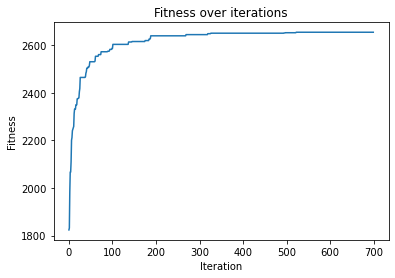

Best Solution: 2655


In [26]:
# crossover rate at 0.5 and mytation rate at 0.05

x = np.arange(num_iterations)
y = np.array(fitness)
plt.title("Fitness over iterations") 
plt.xlabel("Iteration") 
plt.ylabel("Fitness") 
plt.plot(x,y) 
plt.show()
print("Best Solution: " + str(best_soln.fitness))

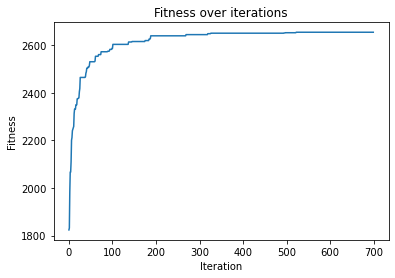
Best Solution 2655

In [ ]:
# The parameters for the problem are changed here 
class parameters:
  def __init__(self):
    self.number_in_population = 700
    self.number_of_iterations = 1000

    #children
    self.child_rate = 1
    self.number_of_children = self.number_in_population * self.child_rate

    #tournament selection parameters
    self.competitors_per_match = 3
    self.matches_per_round = 9

    #Crossover Rate
    self.crossover_rate = 0.5
    self.crossover_explore_rate = 0.5

    #Mutation parameters
    self.mutation_rate = 0.05
    self.mutation_range = 0.5

    #Explore exploit
    self.explore_exploit = .5

In [ ]:
prob = problem()
params = parameters()

In [ ]:
treasure = treasure_hoard(500, 1967)

In [ ]:
best_soln, num_iterations, fitness = run_genetic(prob, params)

In [ ]:
# population at 700 and iterations at 1000

x = np.arange(num_iterations)
y = np.array(fitness)
plt.title("Fitness over iterations") 
plt.xlabel("Iteration") 
plt.ylabel("Fitness") 
plt.plot(x,y) 
plt.show()
print("Best Solution: " + str(best_soln.fitness))

In [ ]:
# attempted higher population and iterations bet kernel would not run.

In [31]:
# The parameters for the problem are changed here 
class parameters:
  def __init__(self):
    self.number_in_population = 500
    self.number_of_iterations = 700

    #children
    self.child_rate = 1
    self.number_of_children = self.number_in_population * self.child_rate

    #tournament selection parameters
    self.competitors_per_match = 3
    self.matches_per_round = 9

    #Crossover Rate
    self.crossover_rate = 0.05
    self.crossover_explore_rate = 0.5

    #Mutation parameters
    self.mutation_rate = 0.05
    self.mutation_range = 0.5

    #Explore exploit
    self.explore_exploit = .5

In [32]:
prob = problem()
params = parameters()

In [33]:
treasure = treasure_hoard(500, 1967)

In [ ]:
best_soln, num_iterations, fitness = run_genetic(prob, params)

In [ ]:
#crossover rate at 0.05 and mtation rate at 0.05
x = np.arange(num_iterations)
y = np.array(fitness)
plt.title("Fitness over iterations") 
plt.xlabel("Iteration") 
plt.ylabel("Fitness") 
plt.plot(x,y) 
plt.show()
print("Best Solution: " + str(best_soln.fitness))